In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(parent_dir, 'scripts'))

import Allen_Connectome_Network as AA
from Allen_Connectome_metadata import *
from F4_functions import *

In [2]:
path_simulations='../data/SBI/ManualExcitabilityTuning/'

# Nodes affected by excitability modulation
subnetworks = ["PFC", "RSC", "ACAv", "MTH", "SS", "VIS", "HYP", "HPC", "TP"]

#  on = baseline, low = inhibition, high = excitation
low_on_high = ["low", "on", "high"]

# Import Simulations

In [3]:
BOLD={}
R={}
PSD={}
ETA={}

for i in tqdm.tqdm(range(len(subnetworks))):
    data = np.load(path_simulations+f"data_{subnetworks[i]:s}.npz")
    avg_r = data['avg_r']     # n_nodes, n_trials
    f = data['f']             # n_freq_samples 129
    psd = data['psd']         # n_trials, n_samples, n_nodes
    eta = data['eta']         # n_nodes, n_trials
    bold_d = data['bold_d']   # n_samples, n_nodes, n_trials
    bold_t = data['bold_t']   # n_samples
    Feature1 = data['feature1'] # n_trials
    Feature2 = data['feature2'] # n_trials

    # Simulated BOLD
    BOLD[subnetworks[i]]={'low':clean_bold(bold_d[:,:,:128]),
                          'on': clean_bold(bold_d[:,:,128:256]),
                          'high':clean_bold(bold_d[:,:,256:])} # n_samples, n_nodes, n_trials   
    
    # Mean Firing Rate for each simulated ROI
    R[subnetworks[i]]={'low':clean_R(avg_r[:,:128]),
                       'on': clean_R(avg_r[:,128:256]),
                       'high':clean_R(avg_r[:,256:])} # n_nodes, n_trials

    # Power Spectral Density for each simulated ROI
    PSD[subnetworks[i]]={'low':clean_psd(psd[:128,:,:]),
                         'on': clean_psd(psd[128:256,:,:]),
                         'high':clean_psd(psd[256:,:,:])} # n_trials, n_samples, n_nodes

    # Excitability values
    ETA[subnetworks[i]]={'low':eta[:,:128],'on': eta[:,128:256],'high':eta[:,256:]} # n_trials, n_samples, n_nodes

    if i == 8:
        print(f.shape, psd.shape, eta.shape, avg_r.shape, bold_d.shape, bold_t.shape, Feature1.shape, Feature2.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.42it/s]

(129,) (384, 129, 108) (148, 384) (108, 384) (332, 108, 384) (332,) (384,) (384,)


# Firing Rate

In [4]:
regions = list(R.keys())
rois = R[regions[0]]['low'].shape[0]

# Initialize an array to store t-statistics
t_stats = np.zeros((len(regions), rois))
p_vals = np.zeros((len(regions), rois))

# Perform t-tests
for i, region in enumerate(regions):
    for roi in range(rois):
        # Extract data for "on" and "low" conditions
        on_data = R[region]['on'][roi, :]
        low_data = R[region]['low'][roi, :]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(low_data, on_data, nan_policy='omit')
        t_stats[i, roi] = t_stat
        p_vals[i, roi] = p_val

# Apply significance threshold
significance_threshold = 0.05
Rt_stats = t_stats
Rmasked_t_stats_low = np.where(p_vals < significance_threshold, t_stats, np.nan)

In [5]:
vmin=-50
vmax=50

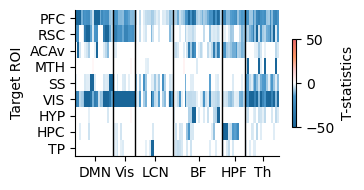

In [6]:
# Plotting the heatmap
plt.figure(figsize=(3.7, 2.))
plt.imshow(Rmasked_t_stats_low[:,order_mod],interpolation='nearest',aspect='auto',cmap=new_cmap,vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label("T-statistics")
for j in range(len(lenmods) - 1):
    plt.axvline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
plt.xticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int),RSNs_mod)
#plt.suptitle(r"Mean Firing Rate") 
#plt.title(r"Decreased $\eta$ VS. Baseline")
plt.yticks(np.arange(len(subnetworks)),subnetworks)
#plt.xlabel("ROIs")
plt.ylabel("Target ROI")
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_FiringRate_inhibition.pdf',dpi=300)
plt.show()

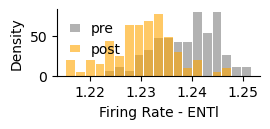

In [7]:
x_base = R['PFC']['on'][32, :]
x_inhib = R['PFC']['low'][32, :]

# Generate points for smooth curves
x_points = np.linspace(min(x_base.min(), x_inhib.min()), max(x_base.max(), x_inhib.max()), 20)

# Define colors
base_color = c_olh[0]
inhib_color = c_olh[1]

# Plotting
plt.figure(figsize=(2.8, 1.4))
plt.hist(x_base, bins=x_points, color=base_color, label='pre',alpha=0.6,rwidth=0.9,density=True)
plt.hist(x_inhib, bins=x_points, color='orange', label='post',alpha=0.6,rwidth=0.9,density=True)
plt.legend(loc='best',frameon=False, handlelength=0.75,  handleheight=0.5)
plt.xlabel('Firing Rate - ENTl')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_R_inhibition_ENT.pdf',dpi=300)
plt.show()


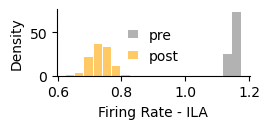

In [8]:
x_base = R['PFC']['on'][17, :]
x_inhib = R['PFC']['low'][17, :]

# Generate points for smooth curves
x_points = np.linspace(min(x_base.min(), x_inhib.min()), max(x_base.max(), x_inhib.max()), 20)

# Define colors
base_color = c_olh[0] 
inhib_color = c_olh[1]

# Plotting
plt.figure(figsize=(2.8, 1.4))
plt.hist(x_base, bins=x_points, color=base_color, label='pre',alpha=0.6,rwidth=0.9)
plt.hist(x_inhib, bins=x_points, color='orange', label='post',alpha=0.6,rwidth=0.9)
plt.legend(loc='best',frameon=False, handlelength=0.75,  handleheight=0.5)
plt.xlabel('Firing Rate - ILA')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_R_inhibition_ILA.pdf',dpi=300)
plt.show()


# Network Plot Graphics

(45.594202898550726, 22.722567287784678)


/Users/giovanni/anaconda3/envs/si_env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


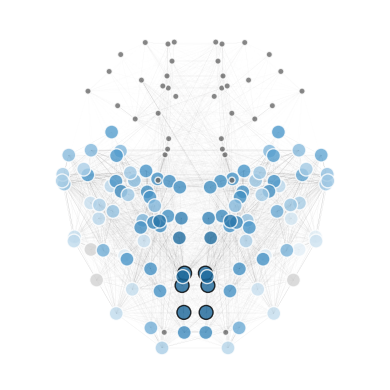

In [9]:
nedges=int((nregions-1)*(nregions/2))
medges=int((mregions-1)*(mregions/2))

k=0
Significance= np.where(~np.isnan(Rmasked_t_stats_low[k,:]))[0]
Class_sil=-1*np.ones(nregions)
Class_sil[reroi]=np.zeros(mregions)
Class_sil[reroi[Significance]]=np.ones(len(Significance))

normalized_values = (Rmasked_t_stats_low[k,Significance] - vmin) / (vmax - vmin)
normalized_values = np.clip(normalized_values, 0, 1)  # Ensure values are within [0, 1]

cmap = new_cmap
hex_colors = [to_hex(cmap(value)) for value in normalized_values]


#Node colors
C0=['dimgray','lightgray','#194540','#3eb370','#a63541']
col=[]
j=0
for i in range(nregions):
    if Class_sil[i]==-1:
        col.append(C0[0])
    if Class_sil[i]==0:
        col.append(C0[1])
    if Class_sil[i]==1:
        col.append(hex_colors[j])
        j+=1
        
# Edge colors
edgcol=[]
for i in range(nedges):
    edgcol.append('#525050')
edgthr=SC[np.triu_indices(148,1)]/1.2

# highlight the silenced ROIs
rimmel=region_map[subnetworks[k]]['indices']
vol=50*np.ones(nregions);
vol[remove_roi]=np.ones(len(remove_roi))*10
alp=0.8

# (matr,w,nodecolor,edgecolor, nsize,al,vmi,vma,colormap,rimmel,sv)
AA.drawMouseStructure(AA.SC,edgthr/4,col,edgcol,2*vol,alp,-0.,0.1,'jet', rimmel,'../figures/Figure4/Inhibited_R_')

# PSD

In [10]:
LOW_FREQ={}
for i in tqdm.tqdm(range(len(subnetworks))):
    LOW_FREQ[subnetworks[i]]={}
    for low_high_on in ["low", "on", "high"]:
        LOW_FREQ[subnetworks[i]][low_high_on]=np.sum(PSD[subnetworks[i]][low_high_on][:,3:20,:],axis=1).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1350.34it/s]


In [11]:
regions = subnetworks
rois = LOW_FREQ[regions[0]]['low'].shape[0]

# Initialize an array to store t-statistics
t_stats = np.zeros((len(regions), rois))
p_vals = np.zeros((len(regions), rois))

# Perform t-tests
for i, region in enumerate(regions):
    for roi in range(rois):
        # Extract data for "on" and "low" conditions
        on_data = LOW_FREQ[region]['on'][roi, :]
        low_data = LOW_FREQ[region]['low'][roi, :]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(low_data, on_data, nan_policy='omit')
        t_stats[i, roi] = t_stat
        p_vals[i, roi] = p_val

# Apply significance threshold
significance_threshold = 0.05
Pt_stats = t_stats
Pmasked_t_stats_low = np.where(p_vals < significance_threshold, t_stats, np.nan)

In [12]:
# Normalize the values to the range [0, 1] based on vmin=0 and vmax=50
vmin = -20
vmax = 20

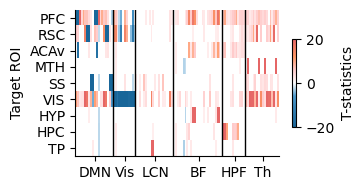

In [13]:
# Plotting the heatmap
plt.figure(figsize=(3.7, 2.))
plt.imshow(Pmasked_t_stats_low[:,order_mod],interpolation='nearest',aspect='auto',cmap=new_cmap,vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label("T-statistics")
for j in range(len(lenmods) - 1):
    plt.axvline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
plt.xticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int),RSNs_mod)
#plt.suptitle(r"Low Frequency Power") 
#plt.title(r"Decreased $\eta$ VS. Baseline")
plt.yticks(np.arange(len(subnetworks)),subnetworks)
#plt.xlabel("ROIs")
plt.ylabel("Target ROI")
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_PSD_inhibition.pdf',dpi=300)
plt.show()

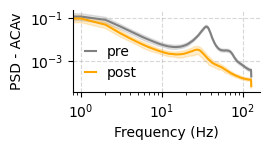

In [14]:
x_base = PSD['PFC']['on'][:,:,16]
x_inhib = PSD['PFC']['low'][:,:,16]
# Compute the mean and standard deviation across the first axis
mean_base = np.mean(x_base, axis=0)
std_base = np.std(x_base, axis=0)

mean_inhib = np.mean(x_inhib, axis=0)
std_inhib = np.std(x_inhib, axis=0)

# Create the x-axis (assuming 129 points along the second axis)
x_axis = np.arange(x_base.shape[1])

plt.figure(figsize=(2.8, 1.6))

# Plot the mean and ±2*STD for x_base
plt.plot(x_axis, mean_base, label='pre', color=base_color, linewidth=1.5)
plt.fill_between(x_axis, mean_base - 2*std_base, mean_base + 2*std_base, color=base_color, alpha=0.2)

# Plot the mean and ±2*STD for x_inhib
plt.plot(x_axis, mean_inhib, label='post', color='orange', linewidth=1.5)
plt.fill_between(x_axis, mean_inhib - 2*std_inhib, mean_inhib + 2*std_inhib, color='orange', alpha=0.2)

# Add labels, legend, and a grid
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD - ACAv')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.5, linestyle='--')
plt.legend(frameon=False, handlelength=0.75, loc='lower left')
plt.tight_layout()

plt.savefig('../figures/Figure4/PNAS_PSD_inhibition_ACAv.pdf',dpi=300)
plt.show()


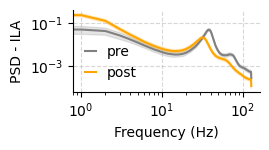

In [15]:
x_base = PSD['PFC']['on'][:,:, 17]
x_inhib = PSD['PFC']['low'][:,:, 17]

mean_base = np.mean(x_base, axis=0)
std_base = np.std(x_base, axis=0)

mean_inhib = np.mean(x_inhib, axis=0)
std_inhib = np.std(x_inhib, axis=0)

# Create the x-axis (assuming 129 points along the second axis)
x_axis = np.arange(x_base.shape[1])


plt.figure(figsize=(2.8, 1.6))

# Plot the mean and ±2*STD for x_base
plt.plot(x_axis, mean_base, label='pre', color=base_color, linewidth=1.5)
plt.fill_between(x_axis, mean_base - 2*std_base, mean_base + 2*std_base, color=base_color, alpha=0.2)

# Plot the mean and ±2*STD for x_inhib
plt.plot(x_axis, mean_inhib, label='post', color='orange', linewidth=1.5)
plt.fill_between(x_axis, mean_inhib - 2*std_inhib, mean_inhib + 2*std_inhib, color='orange', alpha=0.2)

# Add labels, legend, and a grid
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD - ILA')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.5, linestyle='--')
plt.legend(frameon=False, handlelength=0.75, loc='lower left')
plt.tight_layout()

plt.savefig('../figures/Figure4/PNAS_PSD_inhibition_ILA.pdf',dpi=300)
plt.show()


# Network Plot Graphics

In [16]:
k=0
Significance= np.where(~np.isnan(Pmasked_t_stats_low[k,:]))[0]
Class_sil=-1*np.ones(nregions)
Class_sil[reroi]=np.zeros(mregions)
Class_sil[reroi[Significance]]=np.ones(len(Significance))

# normalized_values = np.where(Pmasked_t_stats_low[k,Significance]>vmax,vmax,Pmasked_t_stats_low[k,Significance])
# normalized_values = np.where(normalized_values<vmin,vmin,normalized_values)

normalized_values = (Pmasked_t_stats_low[k,Significance] - vmin) / (vmax - vmin)
normalized_values = np.clip(normalized_values, 0, 1)  # Ensure values are within [0, 1]

cmap = new_cmap
hex_colors = [to_hex(cmap(value)) for value in normalized_values]

In [17]:
#Node colors
C0=['dimgray','lightgray','#194540','#3eb370','#a63541']
col=[]
j=0
for i in range(nregions):
    if Class_sil[i]==-1:
        col.append(C0[0])
    if Class_sil[i]==0:
        col.append(C0[1])
    if Class_sil[i]==1:
        col.append(hex_colors[j])
        j+=1

In [18]:
edgcol=[]
for i in range(nedges):
    edgcol.append('#525050')
edgthr=SC[np.triu_indices(148,1)]/1.2

(45.594202898550726, 22.722567287784678)


/Users/giovanni/anaconda3/envs/si_env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


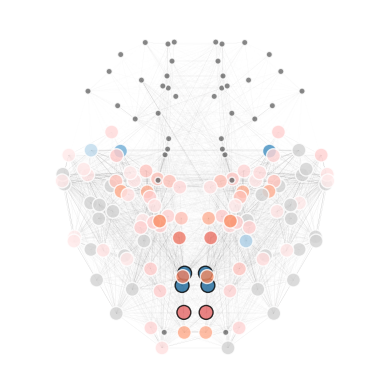

In [19]:
rimmel=region_map[subnetworks[k]]['indices']
vol=50*np.ones(nregions)
vol[remove_roi]=np.ones(len(remove_roi))*10
alp=0.8

# (matr,w,nodecolor,edgecolor, nsize,al,vmi,vma,colormap,rimmel,sv)
AA.drawMouseStructure(AA.SC,edgthr/4,col,edgcol,2*vol,alp,-0.,0.1,'jet',
                        rimmel,'../figures/Figure4/Inhibited_PSD_')

# BOLD

In [22]:
regions = list(BOLD.keys())
rois = BOLD[regions[0]]['low'].shape[1]

# Initialize an array to store t-statistics
t_stats = np.zeros((len(regions), rois))
p_vals = np.zeros((len(regions), rois))

# Perform t-tests
for i, region in enumerate(regions):
    for roi in range(rois):
        # Extract data for "on" and "low" conditions
        on_data = np.mean(compute_corr_matrices(BOLD[region]['on']),axis=1)[:, roi]
        low_data = np.mean(compute_corr_matrices(BOLD[region]['low']),axis=1)[:, roi]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(low_data, on_data, nan_policy='omit')
        t_stats[i, roi] = t_stat
        p_vals[i, roi] = p_val

# Apply significance threshold
significance_threshold = 0.05
Bt_stats = t_stats
Bmasked_t_stats_low = np.where(p_vals < significance_threshold, t_stats, np.nan)

In [23]:
vmin=-5; vmax=5

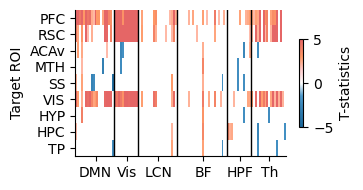

In [24]:
# Plotting the heatmap
plt.figure(figsize=(3.7, 2.))
plt.imshow(Bmasked_t_stats_low[:,order_mod],interpolation='nearest',aspect='auto',cmap=new_cmap,vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label("T-statistics")
for j in range(len(lenmods) - 1):
    plt.axvline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
plt.xticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int),RSNs_mod)
#plt.suptitle(r"Global Connectivity") 
#plt.title(r"Inhibited target VS. Baseline")
plt.yticks(np.arange(len(subnetworks)),subnetworks)
#plt.xlabel("ROIs")
plt.ylabel("Target ROI")
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_FC_inhibition.pdf',dpi=300)
plt.show()

# Network Plot Graphics

In [26]:
k=0
Significance= np.where(~np.isnan(Bmasked_t_stats_low[k,:]))[0]
Class_sil=-1*np.ones(nregions)
Class_sil[reroi]=np.zeros(mregions)
Class_sil[reroi[Significance]]=np.ones(len(Significance))

normalized_values = (Bmasked_t_stats_low[k,Significance] - vmin) / (vmax - vmin)
normalized_values = np.clip(normalized_values, 0, 1)  # Ensure values are within [0, 1]

cmap = new_cmap
hex_colors = [to_hex(cmap(value)) for value in normalized_values]

#Node colors
C0=['dimgray','lightgray','#194540','#3eb370','#a63541']
col=[]
j=0
for i in range(nregions):
    if Class_sil[i]==-1:
        col.append(C0[0])
    if Class_sil[i]==0:
        col.append(C0[1])
    if Class_sil[i]==1:
        col.append(hex_colors[j])
        j+=1

edgcol=[]
for i in range(nedges):
    edgcol.append('#525050')
edgthr=SC[np.triu_indices(148,1)]/1.2

(45.594202898550726, 22.722567287784678)


/Users/giovanni/anaconda3/envs/si_env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


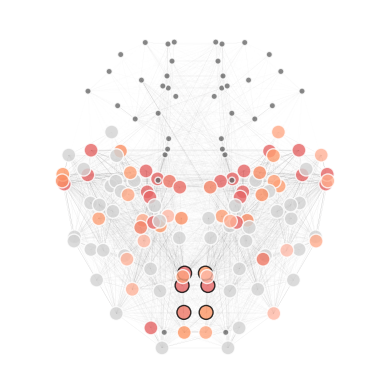

In [27]:
rimmel=region_map[subnetworks[k]]['indices']
vol=50*np.ones(nregions)
vol[remove_roi]=np.ones(len(remove_roi))*10
alp=0.8

# (matr,w,nodecolor,edgecolor, nsize,al,vmi,vma,colormap,rimmel,sv)
AA.drawMouseStructure(AA.SC,edgthr/4,col,edgcol,2*vol,alp,-0.,0.1,'jet', rimmel,'../figures/Figure4/Inhibited_FC_')

In [54]:
# def compute_corr_matrices(data):
#     '''  
#     data: 3D array of shape (time, regions, trials)
#     '''

#     num_trials = data.shape[2]
#     corr_matrices = np.zeros((num_trials, data.shape[1], data.shape[1]))
#     for i in range(num_trials):
#         trial_data = data[:, :, i]  
#         corr_matrix = np.corrcoef(trial_data, rowvar=False)  # (regions, regions)
#         corr_matrices[i, :, :] = corr_matrix
#     return corr_matrices

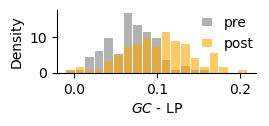

In [28]:
x_base = np.mean(compute_corr_matrices(BOLD['PFC']['on'])[:, :, 47+54],axis=1)
x_inhib = np.mean(compute_corr_matrices(BOLD['PFC']['low'])[:, :, 47+54],axis=1)

# Generate points for smooth curves
x_points = np.linspace(min(x_base.min(), x_inhib.min()), max(x_base.max(), x_inhib.max()), 20)

# Define colors
base_color = c_olh[0]
inhib_color = c_olh[1] 

# Plotting
plt.figure(figsize=(2.8, 1.4))
plt.hist(x_base, bins=x_points, color=base_color, label='pre',alpha=0.6,rwidth=0.9,density=True)
plt.hist(x_inhib, bins=x_points, color='orange', label='post',alpha=0.6,rwidth=0.9,density=True)
plt.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.05, 1.1), handlelength=0.75,  handleheight=0.5)
plt.xlabel('$GC$ - LP')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_GC_inhibition_LP.pdf',dpi=300)
plt.show()


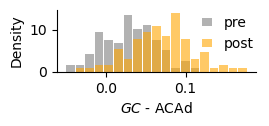

In [29]:
x_base = np.mean(compute_corr_matrices(BOLD['PFC']['on'])[:, :, 15],axis=1)
x_inhib = np.mean(compute_corr_matrices(BOLD['PFC']['low'])[:, :, 15],axis=1)

# Generate points for smooth curves
x_points = np.linspace(min(x_base.min(), x_inhib.min()), max(x_base.max(), x_inhib.max())+0.01, 20)

# Define colors
base_color = c_olh[0] 
inhib_color = c_olh[1] 

# Plotting
plt.figure(figsize=(2.8, 1.4))
plt.hist(x_base, bins=x_points, color=base_color, label='pre',alpha=0.6,rwidth=0.9,density=True)
plt.hist(x_inhib, bins=x_points, color='orange', label='post',alpha=0.6,rwidth=0.9,density=True)
plt.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.05, 1.1), handlelength=0.75,  handleheight=0.5)
plt.xlabel('$GC$ - ACAd')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/Figure4/PNAS_GC_inhibition_ACAd.pdf',dpi=300)
plt.show()


In [ ]:
# Low frequency components

In [30]:
LOW_FREQ={}
for i in tqdm.tqdm(range(len(subnetworks))):
    LOW_FREQ[subnetworks[i]]={}
    for low_high_on in ["low", "on", "high"]:
        LOW_FREQ[subnetworks[i]][low_high_on]=np.sum(PSD[subnetworks[i]][low_high_on][:,3:20,:],axis=1).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1852.34it/s]


In [31]:
regions = subnetworks
rois = LOW_FREQ[regions[0]]['low'].shape[0]

# Initialize an array to store t-statistics
t_stats = np.zeros((len(regions), rois))
p_vals = np.zeros((len(regions), rois))

# Perform t-tests
for i, region in enumerate(regions):
    for roi in range(rois):
        # Extract data for "on" and "low" conditions
        on_data = LOW_FREQ[region]['on'][roi, :]
        low_data = LOW_FREQ[region]['low'][roi, :]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(low_data, on_data, nan_policy='omit')
        t_stats[i, roi] = t_stat
        p_vals[i, roi] = p_val

# Apply significance threshold
significance_threshold = 0.05
Pt_stats = t_stats
Pmasked_t_stats_low = np.where(p_vals < significance_threshold, t_stats, np.nan)

In [32]:
HIGH_FREQ={}
for i in tqdm.tqdm(range(len(subnetworks))):
    HIGH_FREQ[subnetworks[i]]={}
    for low_high_on in ["low", "on", "high"]:
        HIGH_FREQ[subnetworks[i]][low_high_on]=np.sum(PSD[subnetworks[i]][low_high_on][:,40:70,:],axis=1).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1111.66it/s]


In [33]:
regions = subnetworks
rois = HIGH_FREQ[regions[0]]['low'].shape[0]

# Initialize an array to store t-statistics
t_stats = np.zeros((len(regions), rois))
p_vals = np.zeros((len(regions), rois))

# Perform t-tests
for i, region in enumerate(regions):
    for roi in range(rois):
        # Extract data for "on" and "low" conditions
        on_data = HIGH_FREQ[region]['on'][roi, :]
        low_data = HIGH_FREQ[region]['low'][roi, :]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(low_data, on_data, nan_policy='omit')
        t_stats[i, roi] = t_stat
        p_vals[i, roi] = p_val

# Apply significance threshold
significance_threshold = 0.05
HPt_stats = t_stats
HPmasked_t_stats_low = np.where(p_vals < significance_threshold, t_stats, np.nan)

In [34]:
# Normalize the values to the range [0, 1] based on vmin=0 and vmax=50
vmin = -20
vmax = 20

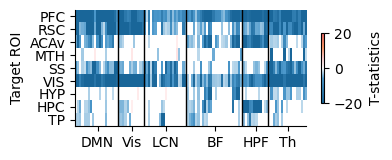

In [35]:
# Plotting the heatmap
plt.figure(figsize=(4, 1.7))
plt.imshow(HPmasked_t_stats_low[:,order_mod],interpolation='nearest',aspect='auto',cmap=new_cmap,vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label("T-statistics")
for j in range(len(lenmods) - 1):
    plt.axvline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
plt.xticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int),RSNs_mod)
#plt.suptitle(r"Low Frequency Power") 
#plt.title(r"Decreased $\eta$ VS. Baseline")
plt.yticks(np.arange(len(subnetworks)),subnetworks)
#plt.xlabel("ROIs")
plt.ylabel("Target ROI")
plt.tight_layout()
plt.savefig('../figures/Figure4/HF_PSD_inhibition.pdf',dpi=300)
plt.show()

In [36]:
R_P_corr=np.zeros(9)
R_B_corr=np.zeros(9)
B_P_corr=np.zeros(9)
for i in range(9):
    R_P_corr[i],_=scipy.stats.spearmanr(Rt_stats[i,:],Pt_stats[i,:])
    R_B_corr[i],_=scipy.stats.spearmanr(Rt_stats[i,:],Bt_stats[i,:])
    B_P_corr[i],_=scipy.stats.spearmanr(Bt_stats[i,:],Pt_stats[i,:])

In [37]:
R_HP_corr=np.zeros(9)
HP_P_corr=np.zeros(9)
B_HP_corr=np.zeros(9)
for i in range(9):
    R_HP_corr[i],_=scipy.stats.spearmanr(Rt_stats[i,:],HPt_stats[i,:])
    HP_P_corr[i],_=scipy.stats.spearmanr(HPt_stats[i,:],Pt_stats[i,:])
    B_HP_corr[i],_=scipy.stats.spearmanr(Bt_stats[i,:],HPt_stats[i,:])

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_6056/1352103875.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = get_cmap('viridis')
/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_6056/1352103875.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = get_cmap('plasma')


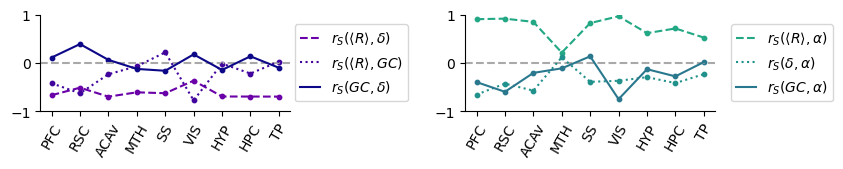

In [39]:
plt.figure(figsize=(9,1.8))
viridis = get_cmap('viridis')
plasma = get_cmap('plasma')

# First subplot with plasma colors
plt.subplot(1, 2, 1)
plt.axhline(0, c='darkgray', linestyle='dashed')
plt.plot(np.arange(9), R_P_corr, linestyle='dashed', label=r'$r_S(\langle R \rangle , \delta)$', color=plasma(0.2))
plt.scatter(np.arange(9), R_P_corr, color=plasma(0.2),s=10)
plt.scatter(np.arange(9), R_B_corr, color=plasma(0.1),s=10)
plt.scatter(np.arange(9), B_P_corr, color=plasma(0.),s=10)
plt.plot(np.arange(9), R_B_corr, linestyle='dotted', label=r'$r_S(\langle R \rangle , GC)$', color=plasma(0.1)) 
plt.plot(np.arange(9), B_P_corr, linestyle='-', label=r'$r_S(GC, \delta)$', color=plasma(0.))
plt.xticks(np.arange(9), subnetworks, rotation=60)
plt.ylim((-1, 1))
legend = plt.legend(bbox_to_anchor=(1.5, .5), loc='center right', fontsize=10, ncol=1,  handlelength=1.4)

# Second subplot with viridis colors  
plt.subplot(1, 2, 2)
plt.axhline(0, c='darkgray', linestyle='dashed')
plt.plot(np.arange(9), R_HP_corr, linestyle='dashed', label=r'$r_S(\langle R \rangle , \alpha)$', color=viridis(0.6))
plt.scatter(np.arange(9), R_HP_corr, color=viridis(0.6),s=10)
plt.plot(np.arange(9), HP_P_corr, linestyle='dotted', label=r'$r_S(\delta , \alpha)$', color=viridis(0.5))
plt.scatter(np.arange(9), HP_P_corr, color=viridis(0.5),s=10)
plt.plot(np.arange(9), B_HP_corr, linestyle='-', label=r'$r_S(GC, \alpha)$', color=viridis(0.4))
plt.scatter(np.arange(9), B_HP_corr, color=viridis(0.4),s=10)
plt.xticks(np.arange(9), subnetworks, rotation=60)
plt.ylim((-1, 1))
#plt.legend(ncol=3)
legend = plt.legend(bbox_to_anchor=(1.5, .5), loc='center right', fontsize=10, ncol=1,  handlelength=1.4)
plt.tight_layout()
plt.subplots_adjust(wspace=0.7, hspace=0.8)
plt.savefig('../figures/Figure4/PNAS_corr_metrics_inh.png',dpi=300)
plt.show()

# SUPPLEMENTARY ANALYSES

# Coarse FC in RSNs

In [41]:

# RSN labels for reference
rsn_labels = ['DMN', 'Vis', 'LCN', 'BF', 'HPF', 'Th']

# Generate all pairs of RSNs (including same RSN pairs like DMN-DMN)
rsn_pairs = []
for i in range(6):
    for j in range(i, 6):  # Keep only the upper triangle (i <= j)
        rsn_pairs.append(f"{rsn_labels[i]}-{rsn_labels[j]}")

# Function to perform independent t-tests on FC data (handling different K)
def independent_ttest_fc(data1, data2):
    # Perform independent t-tests for each pair in the 6x6 FC matrix
    t_stats = np.zeros((6, 6))
    p_values = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            # Perform independent t-test across trials (axis=-1 is across the third dimension: trials)
            t_stat, p_value = ttest_ind(data1[i, j, :], data2[i, j, :], equal_var=False)
            t_stats[i, j] = t_stat
            p_values[i, j] = p_value
    return t_stats, p_values

In [42]:
RSN_names = list(RSNs.keys())  # ['DMN', 'Vis', 'LCN', 'BF', 'HPF', 'Th']
RSN_indices = list(RSNs.values())  # Node indices corresponding to RSNs

FCs = {}
for i, target in enumerate(subnetworks):
    FCs[target] = {}
    bold_data = BOLD[target]

    # Loop over each condition
    for cond in ['on', 'low', 'high']:
        bolds = bold_data[cond]  # Shape: (time, nodes, trials) -> (380, 108, K)

        # Extract the number of trials for this condition
        K = bolds.shape[2]

        # Initialize the (6, 6, K) array to store coarse-grained correlation matrices
        coarse_grained_FC = np.zeros((6, 6, K))

        # Loop over trials
        for trial in range(K):
            # Step 1: Compute the correlation matrix (108, 108) for the current trial
            trial_bold = bolds[:, :, trial]  # Shape: (380, 108)
            corr_matrix = np.corrcoef(trial_bold.T)  # Correlation matrix of shape (108, 108)

            # Step 2: Coarse-grain the correlation matrix by averaging over RSN pairs
            for r1 in range(6):  # Loop over the first RSN
                for r2 in range(6):  # Loop over the second RSN
                    nodes_r1 = RSN_indices[r1]  # Nodes in RSN1
                    nodes_r2 = RSN_indices[r2]  # Nodes in RSN2
                    
                    # Extract the block corresponding to the (r1, r2) RSNs
                    block = corr_matrix[np.ix_(nodes_r1, nodes_r2)]
                    
                    # Step 3: Average within the block and store it
                    coarse_grained_FC[r1, r2, trial] = np.mean(block)

        # Store the coarse-grained FC for this condition and target
        FCs[target][cond] = coarse_grained_FC

# FCs now contains the coarse-grained functional connectivity matrices for each target and condition


In [43]:
targets = list(FCs.keys())

# Initialize storage for t-statistics and significance
t_stats_matrix_low = np.zeros((len(targets), len(rsn_pairs)))  # Rows: Targets, Columns: RSN pairs (upper triangle)
significance_matrix_low = np.zeros((len(targets), len(rsn_pairs)))  # 1 if p-value < 0.05, else 0

# Loop over each target network
for i, target in enumerate(targets):
    # Perform independent t-test between Baseline and High engagement condition
    t_stats, p_values = independent_ttest_fc(FCs[target]['low'], FCs[target]['on'])

    # Extract only the upper triangle of the t_stats and p_values
    flat_t_stats = []
    flat_p_values = []
    for x in range(6):
        for y in range(x, 6):  # Only take upper triangle
            flat_t_stats.append(t_stats[x, y])
            flat_p_values.append(p_values[x, y])
    
    t_stats_matrix_low[i, :] = flat_t_stats
    significance_matrix_low[i, :] = (np.array(flat_p_values) < 0.05).astype(int)

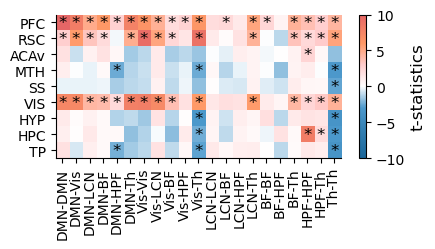

In [64]:
plt.figure(figsize=(4.5, 2.6))
cmap = new_cmap#plt.get_cmap('PRGn')
plt.imshow(t_stats_matrix_low, cmap=cmap, aspect='auto',vmin=-10,vmax=10)

# Add labels for RSN pairs (x-axis) and targets (y-axis)
plt.xticks(np.arange(len(rsn_pairs)), rsn_pairs, rotation=90, ha="center", fontsize=10)
plt.yticks(np.arange(len(targets)), targets, fontsize=10)

# Add color bar to indicate t-statistics values
cbar= plt.colorbar(label='t-statistics')
cbar.set_label('t-statistics', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add asterisks for significant values
for i in range(t_stats_matrix_low.shape[0]):
    for j in range(t_stats_matrix_low.shape[1]):
        if significance_matrix_low[i, j] == 1:
            plt.text(j, i, '*', ha='center', va='center', color='black', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/Supplementary/EdgeFC_inhibition.pdf',dpi=300)
plt.show()


# TIMESERIES

In [46]:
path_out=path_simulations+'ExampleSimulation/'

In [47]:
R_on={}
R_low={}
R_high={}
for i in range(2):
    R_high[i]=np.load(path_out+'higher/R%d_higher.npy'%i)
    R_low[i]=np.load(path_out+'lower/R%d_lower.npy'%i)
    R_on[i]=np.load(path_out+'on/R%d_on.npy'%i)

In [48]:
Rmat_on={}
Rmat_low={}
Rmat_high={}
for i in range(6):
    Rmat_high[i]=np.load(path_out+'higher/Rmat%d_higher.npy'%i)
    Rmat_low[i]=np.load(path_out+'lower/Rmat%d_lower.npy'%i)
    Rmat_on[i]=np.load(path_out+'on/Rmat%d_on.npy'%i)

In [49]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [50]:
time=np.linspace(0,10,500)

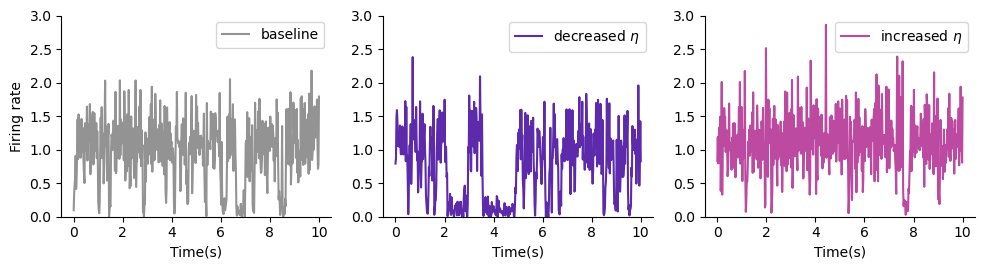

In [51]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
dur=1000
plt.figure(figsize=(10,2.8))
plt.subplot(131)
plt.plot(time,Rmat_on[0][:dur,23][::2],c=c_olh[0],alpha=0.85,label='baseline')
plt.ylabel('Firing rate')
plt.xlabel('Time(s)')
plt.legend()
plt.ylim(0,3)
plt.subplot(133)
plt.plot(time,Rmat_high[0][:dur,23][::2],c=plasma(0.4),alpha=0.85,label='increased $\eta$')
plt.legend()
plt.ylim(0,3)
plt.xlabel('Time(s)')
plt.subplot(132)
plt.plot(time,Rmat_low[0][:dur,23][::2],c=plasma(0.1),alpha=0.85,label='decreased $\eta$')
plt.legend()
plt.ylim(0,3)
plt.xlabel('Time(s)')
plt.tight_layout()
plt.savefig('../figures/Supplementary/Firing_rate_RSC_SIM.pdf')
plt.show()

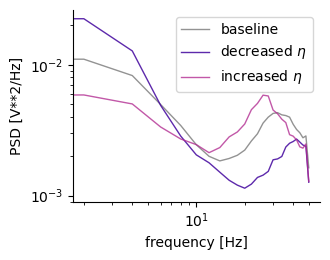

In [52]:
fs=100
plt.figure(figsize=(3.4,2.7))
(f, S)= scipy.signal.welch(Rmat_on[0][:,23], fs, nperseg=50); plt.loglog(f, S,color=c_olh[0],alpha=0.85, label='baseline',linewidth=1)
(f, S)= scipy.signal.welch(Rmat_low[0][:,23], fs, nperseg=50); plt.loglog(f, S,color=plasma(0.1),alpha=0.85, label='decreased $\eta$',linewidth=1)
(f, S)= scipy.signal.welch(Rmat_high[0][:,23], fs, nperseg=50); plt.loglog(f, S,color=plasma(0.4),alpha=0.785, label='increased $\eta$',linewidth=1)
plt.legend()
#plt.xlim([0, 50])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.savefig('../figures/Supplementary/PSD_RSC_SIM.pdf')
plt.show()

# Coarse FC in RSNs

In [53]:
# RSN labels for reference
rsn_labels = ['DMN', 'Vis', 'LCN', 'BF', 'HPF', 'Th']

# Generate all pairs of RSNs (including same RSN pairs like DMN-DMN)
rsn_pairs = []
for i in range(6):
    for j in range(i, 6):  # Keep only the upper triangle (i <= j)
        rsn_pairs.append(f"{rsn_labels[i]}-{rsn_labels[j]}")

# Function to perform independent t-tests on FC data (handling different K)
def independent_ttest_fc(data1, data2):
    # Perform independent t-tests for each pair in the 6x6 FC matrix
    t_stats = np.zeros((6, 6))
    p_values = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            # Perform independent t-test across trials (axis=-1 is across the third dimension: trials)
            t_stat, p_value = ttest_ind(data1[i, j, :], data2[i, j, :], equal_var=False)
            t_stats[i, j] = t_stat
            p_values[i, j] = p_value
    return t_stats, p_values

In [54]:
RSN_names = list(RSNs.keys())  # ['DMN', 'Vis', 'LCN', 'BF', 'HPF', 'Th']
RSN_indices = list(RSNs.values())  # Node indices corresponding to RSNs

FCs = {}
for i, target in enumerate(subnetworks):
    FCs[target] = {}
    bold_data = BOLD[target]

    # Loop over each condition
    for cond in ['on', 'low', 'high']:
        bolds = bold_data[cond]  # Shape: (time, nodes, trials) -> (380, 108, K)

        # Extract the number of trials for this condition
        K = bolds.shape[2]

        # Initialize the (6, 6, K) array to store coarse-grained correlation matrices
        coarse_grained_FC = np.zeros((6, 6, K))

        # Loop over trials
        for trial in range(K):
            # Step 1: Compute the correlation matrix (108, 108) for the current trial
            trial_bold = bolds[:, :, trial]  # Shape: (380, 108)
            corr_matrix = np.corrcoef(trial_bold.T)  # Correlation matrix of shape (108, 108)

            # Step 2: Coarse-grain the correlation matrix by averaging over RSN pairs
            for r1 in range(6):  # Loop over the first RSN
                for r2 in range(6):  # Loop over the second RSN
                    nodes_r1 = RSN_indices[r1]  # Nodes in RSN1
                    nodes_r2 = RSN_indices[r2]  # Nodes in RSN2
                    
                    # Extract the block corresponding to the (r1, r2) RSNs
                    block = corr_matrix[np.ix_(nodes_r1, nodes_r2)]
                    
                    # Step 3: Average within the block and store it
                    coarse_grained_FC[r1, r2, trial] = np.mean(block)

        # Store the coarse-grained FC for this condition and target
        FCs[target][cond] = coarse_grained_FC

# FCs now contains the coarse-grained functional connectivity matrices for each target and condition


In [55]:
targets = list(FCs.keys())

# Initialize storage for t-statistics and significance
t_stats_matrix_high = np.zeros((len(targets), len(rsn_pairs)))  # Rows: Targets, Columns: RSN pairs (upper triangle)
significance_matrix_high = np.zeros((len(targets), len(rsn_pairs)))  # 1 if p-value < 0.05, else 0

# Loop over each target network
for i, target in enumerate(targets):
    # Perform independent t-test between Baseline and High engagement condition
    t_stats, p_values = independent_ttest_fc(FCs[target]['high'], FCs[target]['on'])

    # Extract only the upper triangle of the t_stats and p_values
    flat_t_stats = []
    flat_p_values = []
    for x in range(6):
        for y in range(x, 6):  # Only take upper triangle
            flat_t_stats.append(t_stats[x, y])
            flat_p_values.append(p_values[x, y])
    
    t_stats_matrix_high[i, :] = flat_t_stats
    significance_matrix_high[i, :] = (np.array(flat_p_values) < 0.05).astype(int)

In [56]:
targets = list(FCs.keys())

# Initialize storage for t-statistics and significance
t_stats_matrix_low = np.zeros((len(targets), len(rsn_pairs)))  # Rows: Targets, Columns: RSN pairs (upper triangle)
significance_matrix_low = np.zeros((len(targets), len(rsn_pairs)))  # 1 if p-value < 0.05, else 0

# Loop over each target network
for i, target in enumerate(targets):
    # Perform independent t-test between Baseline and High engagement condition
    t_stats, p_values = independent_ttest_fc(FCs[target]['low'], FCs[target]['on'])

    # Extract only the upper triangle of the t_stats and p_values
    flat_t_stats = []
    flat_p_values = []
    for x in range(6):
        for y in range(x, 6):  # Only take upper triangle
            flat_t_stats.append(t_stats[x, y])
            flat_p_values.append(p_values[x, y])
    
    t_stats_matrix_low[i, :] = flat_t_stats
    significance_matrix_low[i, :] = (np.array(flat_p_values) < 0.05).astype(int)

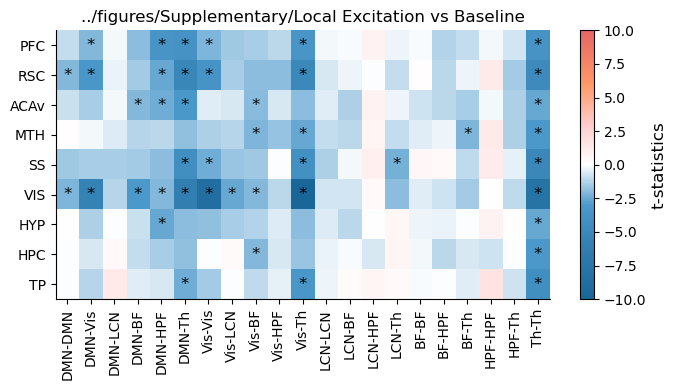

In [57]:
plt.figure(figsize=(7, 4))
cmap = new_cmap#plt.get_cmap('PRGn')
plt.imshow(t_stats_matrix_high, cmap=cmap, aspect='auto',vmin=-10,vmax=10)

# Add labels for RSN pairs (x-axis) and targets (y-axis)
plt.xticks(np.arange(len(rsn_pairs)), rsn_pairs, rotation=90, ha="center", fontsize=10)
plt.yticks(np.arange(len(targets)), targets, fontsize=10)

# Add color bar to indicate t-statistics values
cbar= plt.colorbar(label='t-statistics')
cbar.set_label('t-statistics', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add asterisks for significant values
for i in range(t_stats_matrix_high.shape[0]):
    for j in range(t_stats_matrix_high.shape[1]):
        if significance_matrix_high[i, j] == 1:
            plt.text(j, i, '*', ha='center', va='center', color='black', fontsize=12)

# Title and show plot
plt.title('../figures/Supplementary/Local Excitation vs Baseline', fontsize=12)
plt.tight_layout()
plt.show()


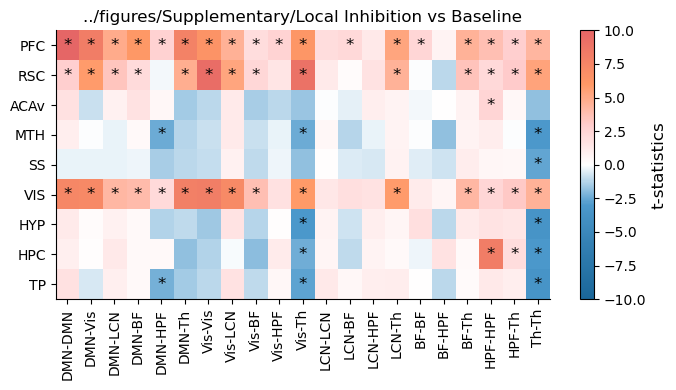

In [58]:
plt.figure(figsize=(7, 4))
cmap = new_cmap#plt.get_cmap('PRGn')
plt.imshow(t_stats_matrix_low, cmap=cmap, aspect='auto',vmin=-10,vmax=10)

# Add labels for RSN pairs (x-axis) and targets (y-axis)
plt.xticks(np.arange(len(rsn_pairs)), rsn_pairs, rotation=90, ha="center", fontsize=10)
plt.yticks(np.arange(len(targets)), targets, fontsize=10)

# Add color bar to indicate t-statistics values
cbar= plt.colorbar(label='t-statistics')
cbar.set_label('t-statistics', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add asterisks for significant values
for i in range(t_stats_matrix_low.shape[0]):
    for j in range(t_stats_matrix_low.shape[1]):
        if significance_matrix_low[i, j] == 1:
            plt.text(j, i, '*', ha='center', va='center', color='black', fontsize=12)

# Title and show plot
plt.title('../figures/Supplementary/Local Inhibition vs Baseline', fontsize=12)
plt.tight_layout()
plt.show()


In [59]:
def compute_corr_matrices(data):
    '''  
    data: 3D array of shape (time, regions, trials)
    '''

    num_trials = data.shape[2]
    corr_matrices = np.zeros((num_trials, data.shape[1], data.shape[1]))
    for i in range(num_trials):
        trial_data = data[:, :, i]  
        corr_matrix = np.corrcoef(trial_data, rowvar=False)  # (regions, regions)
        corr_matrices[i, :, :] = corr_matrix
    return corr_matrices

def get_delta_fcs(bold_b, bold_h, bold_l):
    fc_exc = compute_corr_matrices(bold_h)
    fc_bas = compute_corr_matrices(bold_b)
    fc_inh = compute_corr_matrices(bold_l)
    delta_fc_exc = np.mean(fc_exc, axis=0) - np.mean(fc_bas, axis=0)
    delta_fc_inh = np.mean(fc_inh, axis=0) - np.mean(fc_bas, axis=0)
    return delta_fc_exc, delta_fc_inh

def plot(delta_fc_exc, delta_fc_inh, order_mod, title="", colorbar=False, ax=None, **kwargs):
    
    assert (len(ax) == 2)
    re = np.ix_(order_mod,order_mod)
    im0=ax[1].imshow(delta_fc_exc[re], **kwargs)
    ax[1].set_title(f'{title} post - pre')
    im1=ax[0].imshow(delta_fc_inh[re], **kwargs)
    ax[0].set_title(f'{title} post - pre')
    
    for i in range(2):
        for j in range(len(lenmods) - 1):
            ax[i].axvline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
            ax[i].axhline(np.asarray(np.cumsum(lenmods))[j] - 0.5, linewidth=1, color='k')
            
        ax[i].set_yticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int))
        ax[i].set_yticklabels(short_mod)
        ax[i].set_xticks(np.asarray(np.cumsum(lenmods) - np.asarray(lenmods) / 2, dtype=int))
        ax[i].set_xticklabels(short_mod, rotation=60)  
    
    ims = [im0, im1]
    if colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        for i in range(2):
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ims[i], cax=cax, ax=ax[i])

def coarse_grain(matrix, network_sizes):
    """
    Coarse grain the input matrix based on the network sizes.

    Parameters:
    - matrix (numpy array): The original NxN matrix to be coarse-grained.
    - network_sizes (list of int): List of sizes of each network.

    Returns:
    - block_matrix (numpy array): Coarse-grained matrix of shape (6, 6).
    """
    # Number of networks
    num_networks = len(network_sizes)
    
    # Initialize the (6, 6) matrix to store block averages
    block_matrix = np.zeros((num_networks, num_networks))

    # Define the start and end indices for each network
    network_start_indices = np.cumsum([0] + network_sizes[:-1])
    network_end_indices = np.cumsum(network_sizes)

    # Loop over each pair of networks (i, j)
    for i in range(num_networks):
        for j in range(num_networks):
            # Get the submatrix for network i and network j
            start_i, end_i = network_start_indices[i], network_end_indices[i]
            start_j, end_j = network_start_indices[j], network_end_indices[j]

            submatrix = matrix[start_i:end_i, start_j:end_j]

            # Compute the average of the submatrix
            block_matrix[i, j] = np.mean(submatrix)

    return block_matrix

def plot_coarse(delta_fc_exc, delta_fc_inh, order_mod, title="", colorbar=False, ax=None, **kwargs):
    
    assert (len(ax) == 2)
    re = np.ix_(order_mod,order_mod)
    im0=ax[1].imshow(coarse_grain(delta_fc_exc[re],lenmods), **kwargs)
    ax[1].set_title(f'{title} post - pre')
    im1=ax[0].imshow(coarse_grain(delta_fc_inh[re],lenmods), **kwargs)
    ax[0].set_title(f'{title} post - pre')

    lm=np.ones(len(lenmods))

    for i in range(2):
        for j in range(len(lm)):
            ax[i].axvline(np.asarray(np.cumsum(lm))[j] - 0.5, linewidth=1, color='k')
            ax[i].axhline(np.asarray(np.cumsum(lm))[j] - 0.5, linewidth=1, color='k')
            
        ax[i].set_yticks(np.asarray(np.cumsum(lm) - np.asarray(lm) / 2, dtype=int))
        ax[i].set_yticklabels(short_mod)
        ax[i].set_xticks(np.asarray(np.cumsum(lm) - np.asarray(lm) / 2, dtype=int))
        ax[i].set_xticklabels(short_mod, rotation=60)  
    
    ims = [im0, im1]
    if colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        for i in range(2):
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ims[i], cax=cax, ax=ax[i])  


In [60]:
#nets=['RSCdv', 'ACAv', 'MD']
short_mod=RSNs.keys()

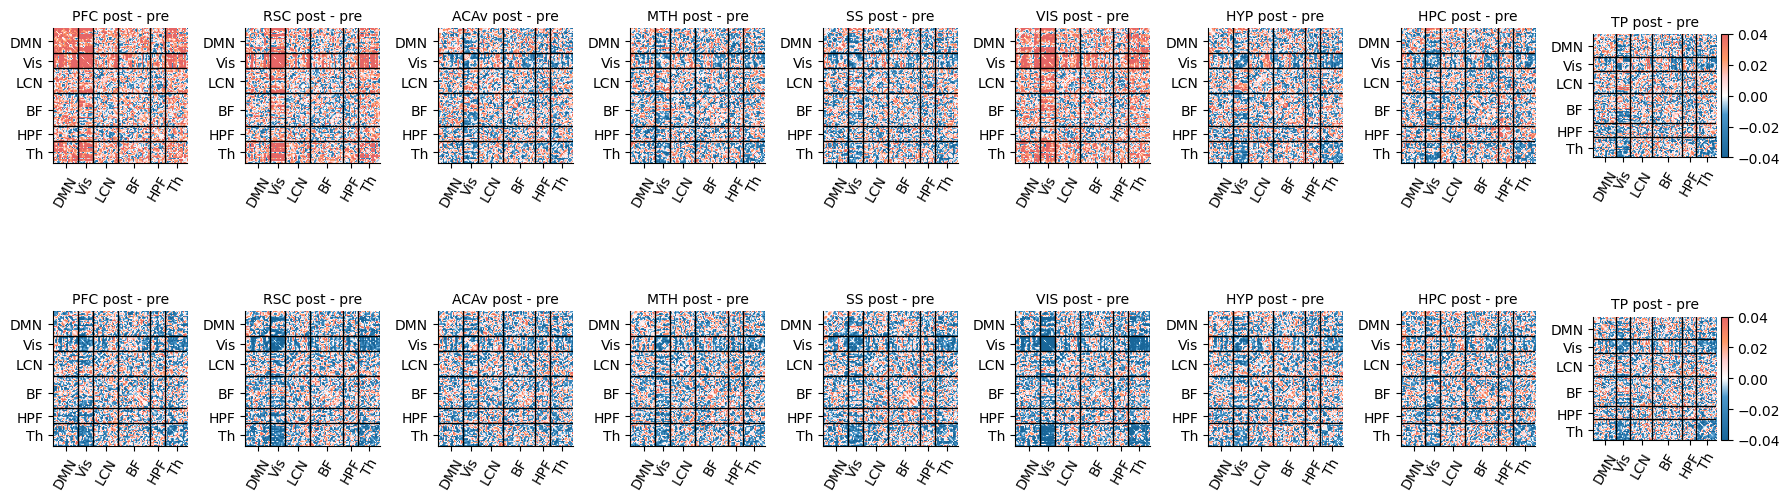

In [61]:
fig, ax = plt.subplots(2,len(subnetworks), figsize=(len(subnetworks)*2, 6))
for i in range(len(subnetworks)):
    bold_h = BOLD[subnetworks[i]]['high']
    bold_l = BOLD[subnetworks[i]]['low']
    bold_b = BOLD[subnetworks[i]]['on']
    delta_fc_exc, delta_fc_inh = get_delta_fcs(bold_b, bold_h, bold_l)
    colorbar=True if i == len(subnetworks) - 1 else False
    plot(delta_fc_exc, delta_fc_inh, order_mod, title=subnetworks[i], ax=ax[:,subnetworks.index(subnetworks[i])], cmap=new_cmap, vmin=-0.04, vmax=0.04, colorbar=colorbar)
plt.tight_layout()
plt.savefig('../figures/Supplementary/Simulated_mats.pdf')


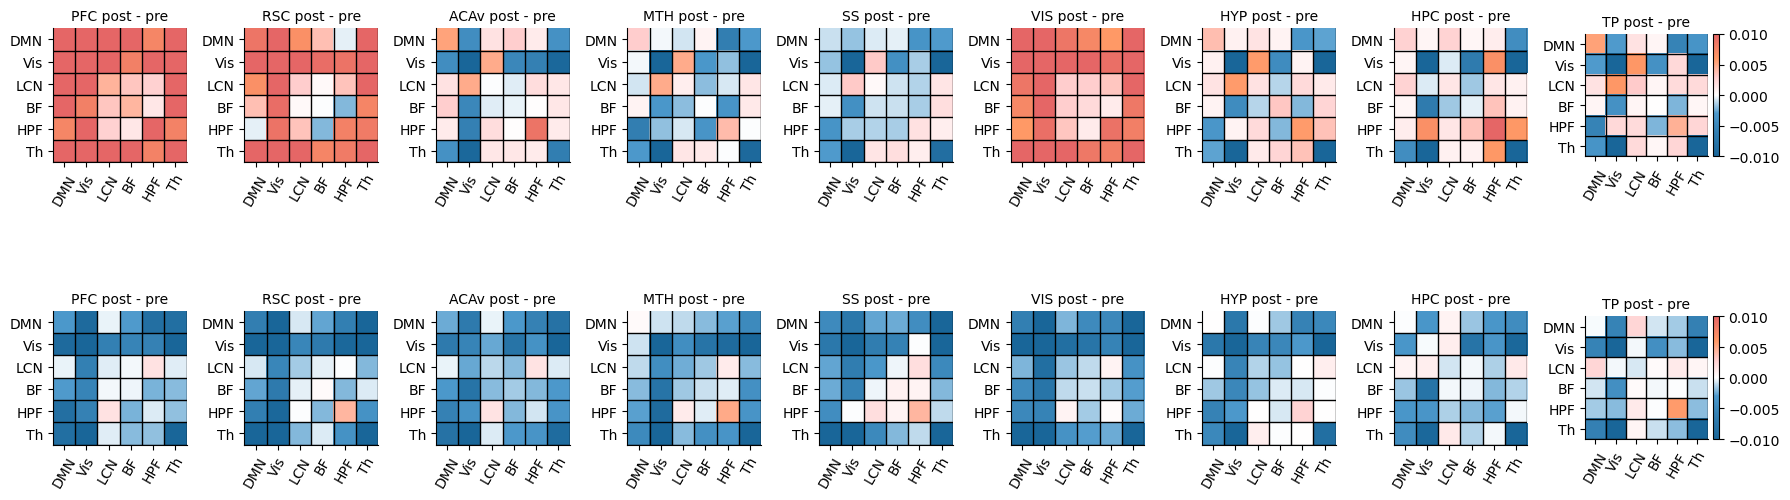

In [62]:
fig, ax = plt.subplots(2,len(subnetworks), figsize=(len(subnetworks)*2, 6))
for i in range(len(subnetworks)):
    bold_h = BOLD[subnetworks[i]]['high']
    bold_l = BOLD[subnetworks[i]]['low']
    bold_b = BOLD[subnetworks[i]]['on']
    delta_fc_exc, delta_fc_inh = get_delta_fcs(bold_b, bold_h, bold_l)
    colorbar=True if i == len(subnetworks) - 1 else False
    plot_coarse(delta_fc_exc, delta_fc_inh, order_mod, title=subnetworks[i], ax=ax[:,subnetworks.index(subnetworks[i])], cmap=new_cmap, vmin=-0.01, vmax=0.01, colorbar=colorbar)
plt.tight_layout()
plt.savefig('../figures/Supplementary/Simulated_mats_coarse.pdf')
